#  Data Wrangling

***
* Prerequisite: 4 csv datasets scraped from Indeed website based on search results with the following keywords:
'data science' 
'data analyst'
'machine learning'
'artifical intelligence'
* Step 1: Data Shape, import data, select top 200 or 50% records from each file, and combine into one dataset
* Step 2: De-duplicate records 
* Step 3: Cleaning Data: Create 'DatePosted' datetime variable based on the value from 'PostDate' and 'ExtractDate'
* Step 4: Cleaning Data: Create 'isRemote' binary variable based on 'Remote' and 'Location'
* Step 5: Cleaning Data: Create 'City', 'State', and 'Region' categorical variables based on 'Location'
* Step 6: Cleaning Data: Create 'isSenior', 'isJunior', and 'isMid' binary variables from job 'Title'
* Step 7: Cleaning Data: Create 'SalaryMidValue' float variable from string value of 'Salary'
* Step 8: Cleaning Data: Create 'CompanyRevenue' categorial variable from companies dataset by merging into dataset. 
* Step 9: Cleaning Data: Create 'CompanySizeGroup' categorical variable from string value of 'CompanySize'
* Step 10: Cleaning Data: Create new binary variables 'isDA', 'isDS', 'isML', 'isAI' from job 'Title'
* Step 11: Drop unnecessary string variables 
* Step 12: Save the result into one csv file in the intrim fold 
***

In [8]:
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
# Add project path
parent_project_path = os.path.abspath(os.path.join('..'))
if parent_project_path not in sys.path:
    sys.path.append(parent_project_path)
from src.library.sb_utils import save_file

### Step 1: Data Shape
* Import data
* Select top 200 or 50% records from each files except for 'da' (only include 30%) and combine into one single dataset

In [9]:
# Import data
today = datetime.today().strftime('%Y_%m_%d')
dfNames=['da','ds','ml','ai']

list_of_df = []
data = pd.DataFrame()

for n in dfNames:
    fileName = '../data/raw/{0}_last{1}d_RC_{2}.csv'.format(n,'1', today)
    df = pd.read_csv(fileName, skiprows=[0])
    print(df.shape)
    
    #combine 4 files together
    if n == 'da':
        data = data.append(df.head(int(df.shape[0] * 0.3)), ignore_index=True)
    else:
        if df.shape[0] * 0.5 >200:
            data = data.append(df.head(200), ignore_index=True)
        else:
            data = data.append(df.head(int(df.shape[0] * 0.5)), ignore_index=True)       
   
    print(data.shape)


(55, 16)
(16, 16)
(107, 16)
(69, 16)
(67, 16)
(102, 16)
(53, 16)
(128, 16)


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   JobID            128 non-null    object 
 1   JobTitle         128 non-null    object 
 2   Company          128 non-null    object 
 3   Location         128 non-null    object 
 4   CompanyRating    89 non-null     float64
 5   CompanyUrl       89 non-null     object 
 6   CompanyIndustry  78 non-null     object 
 7   CompanySize      78 non-null     object 
 8   PostDate         128 non-null    object 
 9   ExtractDate      128 non-null    object 
 10  Summary          128 non-null    object 
 11  Salary           11 non-null     object 
 12  Remote           39 non-null     object 
 13  JobUrl           128 non-null    object 
 14  JobDetail        24 non-null     object 
 15  JobDescription   42 non-null     object 
dtypes: float64(1), object(15)
memory usage: 16.1+ KB


### Step 2: De - duplicate records with same JobID
There are overlaps betweem 4 datasets


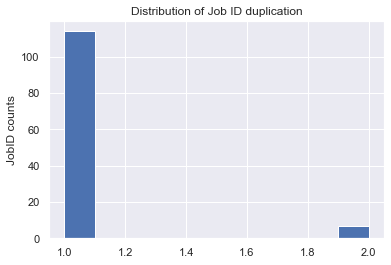

In [11]:
data.JobID.value_counts().plot(kind='hist')
plt.title('Distribution of Job ID duplication')
plt.ylabel('JobID counts')
plt.xlabel('')
plt.show()

In [12]:
#Group by column having count > 1 
#data.groupby('JobID').filter(lambda x: len(x) >1 ).sort_values('JobID')

In [13]:
data.JobID.describe()

count                  128
unique                 121
top       b0e3afcde5d20025
freq                     2
Name: JobID, dtype: object

In [14]:
data.duplicated(subset ='JobID').sum()

7

In [15]:
# To de-dup the records in the combined file
data.drop_duplicates(subset = 'JobID', inplace= True)
data.JobID.describe()

count                  121
unique                 121
top       e2ba48a8292a7294
freq                     1
Name: JobID, dtype: object

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 121 entries, 0 to 127
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   JobID            121 non-null    object 
 1   JobTitle         121 non-null    object 
 2   Company          121 non-null    object 
 3   Location         121 non-null    object 
 4   CompanyRating    85 non-null     float64
 5   CompanyUrl       85 non-null     object 
 6   CompanyIndustry  74 non-null     object 
 7   CompanySize      74 non-null     object 
 8   PostDate         121 non-null    object 
 9   ExtractDate      121 non-null    object 
 10  Summary          121 non-null    object 
 11  Salary           10 non-null     object 
 12  Remote           38 non-null     object 
 13  JobUrl           121 non-null    object 
 14  JobDetail        23 non-null     object 
 15  JobDescription   41 non-null     object 
dtypes: float64(1), object(15)
memory usage: 16.1+ KB


In [17]:
# To reindex 
data.index = np.arange(0,len(data))

### Step 3: Create a new variable 'DatePosted' as the exact date of job posted

In [18]:
data.PostDate.unique()

array(['Today', 'Just posted', '1 day ago'], dtype=object)

In [19]:
data.PostDate.str.contains('ago').sum()

8

In [20]:
# To create a new variable 'DatePosted' by remove the string from 'PostDate' and convert to int
data['DatePosted'] = data.PostDate.str.replace('day ago|days ago','').str.replace('Today|Just posted','0').str.strip().astype(int)

In [21]:
data.DatePosted.unique()

array([0, 1])

In [22]:
data.DatePosted.dtypes

dtype('int32')

In [23]:
# To convert 'ExtractDate' to datetime type
data['ExtractDate'] = pd.to_datetime(data['ExtractDate'])

In [24]:
# To Convert 'DatePosted' from int to timeDelta type and compute the exact date when the job was posted 
data.DatePosted = pd.to_timedelta(data.DatePosted, unit='D')
data.DatePosted = pd.to_datetime(data['ExtractDate'] - data['DatePosted'])


In [25]:
data.loc[:,['PostDate','ExtractDate','DatePosted']]

,PostDate,ExtractDate,DatePosted
0,Today,2021-05-24,2021-05-24
1,Today,2021-05-24,2021-05-24
2,Today,2021-05-24,2021-05-24
3,Today,2021-05-24,2021-05-24
4,Today,2021-05-24,2021-05-24
...,...,...,...
116,Today,2021-05-24,2021-05-24
117,Today,2021-05-24,2021-05-24
118,Today,2021-05-24,2021-05-24
119,Just posted,2021-05-24,2021-05-24


### Step 4: Create a new variable 'isRemote' and assign boolean value based on varible 'Remote' OR 'Location'

In [26]:
data.Remote.unique()

array([nan, 'Remote', 'Temporarily remote'], dtype=object)

In [27]:
data.Remote.describe()

count         38
unique         2
top       Remote
freq          31
Name: Remote, dtype: object

In [28]:
# Work on the contingency table (pivot talbe) between Location and Remote
s_Location = data.Location.copy()
s_Location[s_Location != 'Remote'] = 'Others'
s_Location.describe()

count        121
unique         2
top       Others
freq         111
Name: Location, dtype: object

In [29]:
s_Remote = data.Remote.copy()
s_Remote[s_Remote != 'Remote'] = 'Others'
s_Remote.describe()

pd.crosstab(s_Location, s_Remote)

Remote,Others,Remote
Location,,
Others,80,31
Remote,10,0


In [30]:
# try to construct contingency table directly from dataframe using groupby
#[('Others' if (l!='Remote') else l, 'Others' if (r!='Remote') else r )   for l,r in data['Location','Remote']]  #.groupby(by =['Location', 'Remote']).agg('count')

In [31]:
data.Location.str.contains('Remote|United States').sum()

11

In [32]:
((data.Location =='Remote') | (data.Location =='United States')).sum()

11

In [33]:
# To assign the value of Remote to the variable 'Remote' if the value of location is 'Remote'
# It maynot be necessary since we not going to use varialbe 'Remote' later
#data.loc[data.Location.str.contains('Remote'),'Remote'] = 'Remote'

In [34]:
# To create a new boolean variable 'isRemote' and assign Ture if varible 'Remote' OR 'Location' is Remote
data['isRemote'] = (data.Remote == 'Remote') | data.Location.str.contains('Remote|United States')
data.isRemote.describe()

count       121
unique        2
top       False
freq         79
Name: isRemote, dtype: object

### Step 5: Extract city, state information from Location, Create new variables 'City', ‘State', and 'Region' 


In [35]:
data.Location.describe()

count              121
unique              71
top       New York, NY
freq                16
Name: Location, dtype: object

In [36]:
# random imputation will replace 'Remote' and 'United States' values with some
# random observed values of the Location, which has about 10% missing rate
data['Location_imp'] = data.Location

In [37]:
data.Location_imp.str.contains('Remote|United States').sum()

11

In [38]:
data.Location_imp = data.Location_imp.str.replace('Remote|United States','').replace('',np.NaN)

In [39]:
data.Location_imp.value_counts()

New York, NY         16
California            7
Washington, DC        5
Atlanta, GA           4
San Francisco, CA     3
                     ..
New York State        1
Belle Mead, NJ        1
Las Vegas, NV         1
Detroit, MI           1
Bethesda, MD          1
Name: Location_imp, Length: 69, dtype: int64

In [40]:
data.Location_imp.isnull().sum()/len(data)*100, data.Location_imp.isnull().sum()

(9.090909090909092, 11)

In [41]:
number_missing = data.Location_imp.isnull().sum()
observed_values = data.loc[data.Location_imp.notnull(),'Location']
data.loc[data.Location_imp.isnull(), 'Location_imp'] = np.random.choice(observed_values, number_missing, replace=True)

In [42]:
data.Location_imp.value_counts()

New York, NY        18
California           7
Los Angeles, CA      5
Washington, DC       5
Austin, TX           4
                    ..
Las Vegas, NV        1
Chesterfield, VA     1
Chapel Hill, NC      1
Falls Church, VA     1
Bethesda, MD         1
Name: Location_imp, Length: 69, dtype: int64

In [43]:
data.Location_imp.isnull().sum()

0

In [44]:
# To create two new variables City and State
newDf = data.Location_imp.str.split(pat =',',expand =True)
data['City'] = newDf[0]
data['State'] = newDf[1]

In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 121 entries, 0 to 120
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   JobID            121 non-null    object        
 1   JobTitle         121 non-null    object        
 2   Company          121 non-null    object        
 3   Location         121 non-null    object        
 4   CompanyRating    85 non-null     float64       
 5   CompanyUrl       85 non-null     object        
 6   CompanyIndustry  74 non-null     object        
 7   CompanySize      74 non-null     object        
 8   PostDate         121 non-null    object        
 9   ExtractDate      121 non-null    datetime64[ns]
 10  Summary          121 non-null    object        
 11  Salary           10 non-null     object        
 12  Remote           38 non-null     object        
 13  JobUrl           121 non-null    object        
 14  JobDetail        23 non-null     object   

In [46]:
# To clean up values of City ???? whether to treat special case 'United States' as Remote as well????
data.loc[data.City == 'Remote', 'City'] = np.nan
data.loc[data.City == 'United States', 'City'] = np.nan

In [47]:
assert data.City.str.contains('Remote|United States').any()  == False

In [49]:
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

In [50]:
data.loc[((data.State.isnull()) & (~data.City.isnull())), 'City']


28           California
29           California
31       New York State
39           California
44              Florida
45           California
46           California
54     Washington State
84           California
90           California
114             Georgia
Name: City, dtype: object

In [51]:
# To fill the missing value of 'State' from 'City' for those which has only location of State 
data.State.fillna(data.City, inplace=True)

In [52]:
# To clean up values in 'City'
data.loc[data.State == data.City, 'City'] = np.nan

In [53]:
data.State.unique()

array([' NY', ' NJ', ' CA', ' MA', ' TX', ' NC', ' GA', ' MN', ' MD',
       ' WA', ' RI', ' DC', ' CT', ' VA', 'California', 'New York State',
       ' MO', 'Florida', ' PA', ' NV', 'Washington State', ' AZ', ' TN',
       ' FL', ' MI', ' IL', ' CO', ' OH', 'Georgia'], dtype=object)

In [54]:
# To extract State abbrevation value from City variables to fill those missing values into 'State'
data.loc[data.State.str.len() >3,'State']=data.loc[data.State.str.len() >3,'State'].str.replace(' State','').map(us_state_abbrev)



In [55]:
# To clean up the State values
data.State= data.State.str.strip()

In [56]:
data.loc[:,['Location','Location_imp','City','State']]

,Location,Location_imp,City,State
0,"New York, NY","New York, NY",New York,NY
1,"Lake Hiawatha, NJ","Lake Hiawatha, NJ",Lake Hiawatha,NJ
2,"New York, NY","New York, NY",New York,NY
3,"Torrance, CA","Torrance, CA",Torrance,CA
4,"Hoboken, NJ","Hoboken, NJ",Hoboken,NJ
...,...,...,...,...
116,Remote,"Allston, MA",Allston,MA
117,Remote,"New York, NY",New York,NY
118,"Irving, TX","Irving, TX",Irving,TX
119,"Minneapolis, MN","Minneapolis, MN",Minneapolis,MN


In [58]:
# To cleaning up the value of 'Washington DC' on variable 'City'
data.loc[(data.City == 'Washington') & (data.State == 'DC'), 'City'] ='DC'

In [59]:
# special cases "New York, NY"
data.loc[data.City.isin(us_state_abbrev.keys()), ['Location','Location_imp','City','State']]

,Location,Location_imp,City,State
0,"New York, NY","New York, NY",New York,NY
2,"New York, NY","New York, NY",New York,NY
8,"New York, NY","New York, NY",New York,NY
14,"New York, NY","New York, NY",New York,NY
22,"New York, NY","New York, NY",New York,NY
24,"New York, NY","New York, NY",New York,NY
27,"New York, NY","New York, NY",New York,NY
33,"New York, NY","New York, NY",New York,NY
36,"New York, NY","New York, NY",New York,NY
38,"New York, NY","New York, NY",New York,NY


In [573]:
data.State.unique()

array(['NY', 'NJ', 'PA', 'WA', 'IA', 'MA', 'TX', 'IN', 'NH', 'VA', 'MI',
       'CA', 'WI', 'ME', 'UT', 'NC', 'CT', 'MN', 'TN', 'NM', 'AZ', 'IL',
       'DC', 'FL', 'OR', 'OH', 'GA', 'CO', 'AK', 'LA', 'MO', 'RI', 'MD',
       'DE', 'NV', 'SC', 'AL', 'OK', 'KY', 'KS', 'SD', 'ID'], dtype=object)

In [574]:
# To categorize state value into 4 regions 
us_state_regions = {
    'Alabama': 'South',
    'Alaska': 'West',
    'American Samoa': 'Islands',
    'Arizona': 'West',
    'Arkansas': 'South',
    'California': 'West',
    'Colorado': 'West',
    'Connecticut': 'Northeast',
    'Delaware': 'South',
    'District of Columbia': 'South',
    'Florida': 'South',
    'Georgia': 'South',
    'Guam': 'Islands',
    'Hawaii': 'West',
    'Idaho': 'West',
    'Illinois': 'Midwest',
    'Indiana': 'Midwest',
    'Iowa': 'Midwest',
    'Kansas': 'Midwest',
    'Kentucky': 'South',
    'Louisiana': 'South',
    'Maine': 'Northeast',
    'Maryland': 'South',
    'Massachusetts': 'Northeast',
    'Michigan': 'Midwest',
    'Minnesota': 'Midwest',
    'Mississippi': 'South',
    'Missouri': 'Midwest',
    'Montana': 'West',
    'Nebraska': 'Midwest',
    'Nevada': 'West',
    'New Hampshire': 'Northeast',
    'New Jersey': 'Northeast',
    'New Mexico': 'West',
    'New York': 'Northeast',
    'North Carolina': 'South',
    'North Dakota': 'Midwest',
    'Northern Mariana Islands':'Islands',
    'Ohio': 'Midwest',
    'Oklahoma': 'South',
    'Oregon': 'West',
    'Pennsylvania': 'Northeast',
    'Puerto Rico': 'Islands',
    'Rhode Island': 'Northeast',
    'South Carolina': 'South',
    'South Dakota': 'Midwest',
    'Tennessee': 'South',
    'Texas': 'South',
    'Utah': 'West',
    'Vermont': 'Northeast',
    'Virgin Islands': 'Islands',
    'Virginia': 'South',
    'Washington': 'West',
    'West Virginia': 'South',
    'Wisconsin': 'Midwest',
    'Wyoming': 'West'
}

In [575]:
us_state_regions_mapping =  {v: us_state_regions[k] for k, v in us_state_abbrev.items()}

In [576]:
# To create a new variable 'Region' by mapping to the dict
data['Region'] = data.loc[~data.State.isnull(),'State'].map(us_state_regions_mapping).astype('category')

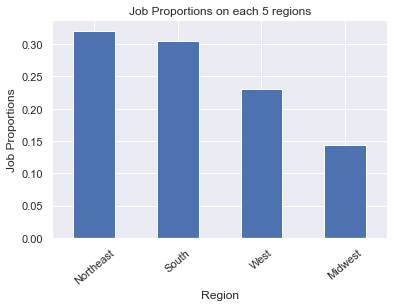

In [577]:
data.Region.value_counts(normalize=True).plot(kind='bar')
plt.ylabel('Job Proportions')
plt.xlabel('Region')
plt.xticks(rotation=40)
plt.title('Job Proportions on each 5 regions')
plt.show()

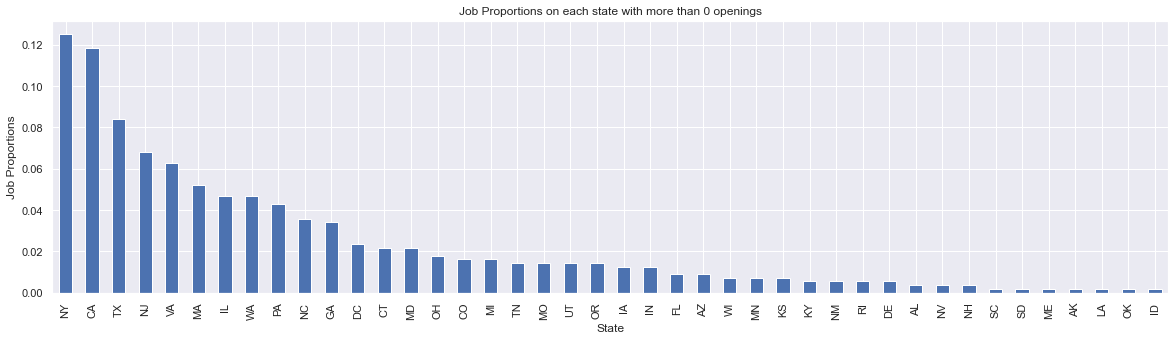

In [578]:
plt.subplots(figsize=(20, 5))
data.State.value_counts(normalize =True).plot(kind='bar')
plt.ylabel('Job Proportions')
plt.xlabel('State')
plt.title('Job Proportions on each state with more than 0 openings')
plt.show()

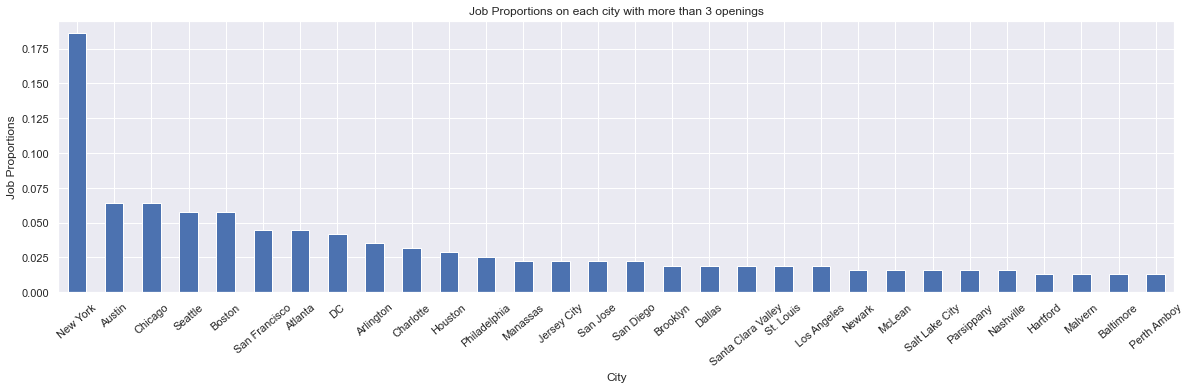

In [579]:
plt.subplots(figsize=(20, 5))
data.groupby('City').filter(lambda x: len(x) >3 )['City'].value_counts(normalize=True).plot(kind='bar')
plt.xticks(rotation=40)
plt.ylabel('Job Proportions')
plt.xlabel('City')
plt.title('Job Proportions on each city with more than 3 openings')
plt.show()     

In [580]:
data.City.str.contains('Princeton').sum()

2

### Step 6: Create new variables 'isSenior', 'isJunior', and 'isMid' from job Title

In [233]:
data.JobTitle.unique()

array(['Data Analyst, Partner Analytics',
       'Data Analyst, Data Privacy (Privacy Engineering), Disney Streaming',
       'Epic Clarity Data Model Consultant',
       'Data Analyst- Consultant - Energy, Sustainability and Infrastructure,',
       'Senior Data Analyst, Platform Analytics',
       'Data Analyst Statician', 'Quality/ Data Analyst - Tableau',
       'Health System Data Analyst', 'Financial Data Analyst',
       'Business Analyst', 'Senior Reports & Data Analyst',
       'Cancer Data Analyst, Norton Cancer Registry, Days',
       'Functional Data Analyst - non Financial', 'Data Scientist',
       'Principal Data Engineer (Remote)',
       '2021 North American Virtual Research Forum- 8/30 - 9/3',
       'Data Visualization Designer', 'Health Policy Summer Internship',
       'Data Scientist, Production Engineering Spares',
       'Part-Time Student-Material Flow Data Analytics-East Moline IL',
       'SVP, General Manager (Virtual Primary and Specialty care)',
       'Da

In [234]:
# these may not be necessary
#data['JobTitle'] = data['JobTitle'].astype('str')
#type(data.JobTitle[0])

In [235]:
data['isSenior'] = data.JobTitle.str.contains('Senior|Sr|sr|Director|VP|Lead|Principal|Chief')

In [236]:
data['isJunior'] = data.JobTitle.str.contains('Junior|Jr|jr|Intern')

In [237]:
data['isMid'] = data.JobTitle.str.contains('Mid Level|Mid-')

In [238]:
data.loc[:, ['JobTitle','isSenior','isJunior','isMid']].head(3)

,JobTitle,isSenior,isJunior,isMid
0,"Data Analyst, Partner Analytics",False,False,False
1,"Data Analyst, Data Privacy (Privacy Engineerin...",False,False,False
2,Epic Clarity Data Model Consultant,False,False,False


In [239]:
data[data.JobTitle.str.contains('Mid Level|Mid-')]

,JobID,JobTitle,Company,Location,CompanyRating,CompanyUrl,CompanyIndustry,CompanySize,PostDate,ExtractDate,...,JobDetail,JobDescription,DatePosted,isRemote,City,State,Region,isSenior,isJunior,isMid


### Step 7: Process Salary data, and create new variables SalaryMidValue

In [240]:
# string, dict, list appear as Object in df, however, the type can be tested as individual cell
# data.Salary = data.Salary.astype(str) # this cause missing value from NaN to 'nan'
type(data.Salary[0])


float

In [241]:
# the $ that prevents the substring to be found
data.Salary.str.contains('103,690 ').sum()

0

In [242]:
data.loc[(data.Salary =='$103,690 - $134,798 a year') & (data.isRemote), 'JobDescription']#.iloc[0]

Series([], Name: JobDescription, dtype: object)

In [243]:
#data.Salary.unique()

In [244]:
# To create a new variable 'SalaryUnit'
data['SalaryUnit'] = data.Salary.str.extract('(an hour|a year|a month|a week|per class|a day)', expand = True)
data['SalaryUnit'].unique()

array([nan, 'a year', 'an hour', 'a month'], dtype=object)

In [245]:
# using regular expression
data.Salary.str.replace('[^0-9-.]','').unique()

array([nan, '135000', '90.00-115.04', '24.36', '104000-109000',
       '15000-30000', '125000-150000', '75000-100000', '187000-231000',
       '65597-121543', '110000', '93494-143624', '80000-152193',
       '100000-150000', '75000', '77488-141548', '60000'], dtype=object)

In [246]:
data.loc[data.Salary.str.contains('\+') == True]

,JobID,JobTitle,Company,Location,CompanyRating,CompanyUrl,CompanyIndustry,CompanySize,PostDate,ExtractDate,...,JobDescription,DatePosted,isRemote,City,State,Region,isSenior,isJunior,isMid,SalaryUnit


In [247]:
# To create a new variable 'SalaryMidValue' going to contain the mid point value for the arrange of salary
#data['SalaryMidValue'] = data['Salary'].str.replace('an hour|a year|a month|a week|per class|a day','').str.replace('$','').str.replace(',','')

data['SalaryMidValue'] = data.Salary.str.replace('[^0-9-.]','')
data.loc[~data.Salary.isnull(),['Salary','SalaryUnit','SalaryMidValue']].head(4)

,Salary,SalaryUnit,SalaryMidValue
2,"Up to $135,000 a year",a year,135000
5,$90.00 - $115.04 an hour,an hour,90.00-115.04
7,$24.36 an hour,an hour,24.36
10,"$104,000 - $109,000 a year",a year,104000-109000


In [248]:
data.columns



Index(['JobID', 'JobTitle', 'Company', 'Location', 'CompanyRating',
       'CompanyUrl', 'CompanyIndustry', 'CompanySize', 'PostDate',
       'ExtractDate', 'Summary', 'Salary', 'Remote', 'JobUrl', 'JobDetail',
       'JobDescription', 'DatePosted', 'isRemote', 'City', 'State', 'Region',
       'isSenior', 'isJunior', 'isMid', 'SalaryUnit', 'SalaryMidValue'],
      dtype='object')

In [249]:
# Set busniss rule to treat range and Ignore 'Up to' and 'From' 
#data['SalaryMidValue'] = data.SalaryMidValue.str.replace('Up to|From','').str.strip()
#data.SalaryMidValue.unique()

In [250]:
# Take mid value for range salary
s_df = data.SalaryMidValue.str.split(pat ='-',expand =True)
s_df[1].fillna(s_df[0], inplace=True)

data['SalaryMidValue']  = (s_df[1].astype(float)+s_df[0].astype(float))/2


In [251]:
data.loc[~data.Salary.isnull(),['Salary','SalaryUnit','SalaryMidValue']].head(4)

,Salary,SalaryUnit,SalaryMidValue
2,"Up to $135,000 a year",a year,135000.00
5,$90.00 - $115.04 an hour,an hour,102.52
7,$24.36 an hour,an hour,24.36
10,"$104,000 - $109,000 a year",a year,106500.00


In [252]:
data.loc[data.SalaryMidValue >100000,['Salary','SalaryUnit','SalaryMidValue']].sort_values('SalaryMidValue').tail(10)

,Salary,SalaryUnit,SalaryMidValue
175,"$80,000 - $152,193 a year",a year,116096.5
174,"$93,494 - $143,624 a year",a year,118559.0
176,"$100,000 - $150,000 a year",a year,125000.0
2,"Up to $135,000 a year",a year,135000.0
113,"$125,000 - $150,000 a year",a year,137500.0
141,"$187,000 - $231,000 a year",a year,209000.0
144,"$187,000 - $231,000 a year",a year,209000.0
146,"$187,000 - $231,000 a year",a year,209000.0
148,"$187,000 - $231,000 a year",a year,209000.0
149,"$187,000 - $231,000 a year",a year,209000.0


In [253]:
# Convert hourly rate to Salary based on formula hr * 40 * 52 
data.loc[data.SalaryUnit.str.contains('hour', na=False),'SalaryMidValue'] = data.SalaryMidValue * 40 * 52

In [254]:
# Convert monthly rate to Salary based on formula mr * 12
data.loc[data.SalaryUnit.str.contains('month', na=False),'SalaryMidValue'] = data.SalaryMidValue * 12

In [255]:
# Convert weekly rate to Salary based on fomula wr * 52 
data.loc[data.SalaryUnit.str.contains('week', na = False), 'SalaryMidValue'] =data.SalaryMidValue * 52

In [256]:
# Convert daily rate to Salary based on formula dr * 5 * 52
data.loc[data.SalaryUnit.str.contains('day', na=False),'SalaryMidValue'] = data.SalaryMidValue * 5 * 52

In [257]:
# Ignore the teaching job
data.loc[data.SalaryUnit.str.contains('class', na=False),'SalaryMidValue'] = np.nan

In [258]:
print(data.SalaryMidValue.describe())

count        56.000000
mean     224520.605357
std       71627.331427
min       50668.800000
25%      209000.000000
50%      270000.000000
75%      270000.000000
max      270000.000000
Name: SalaryMidValue, dtype: float64


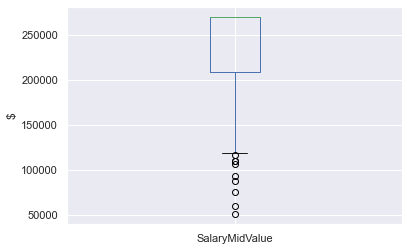

In [259]:
data.SalaryMidValue.plot(kind='box')
plt.ylabel('$')
plt.show()

In [260]:
import seaborn as sns
sns.set()

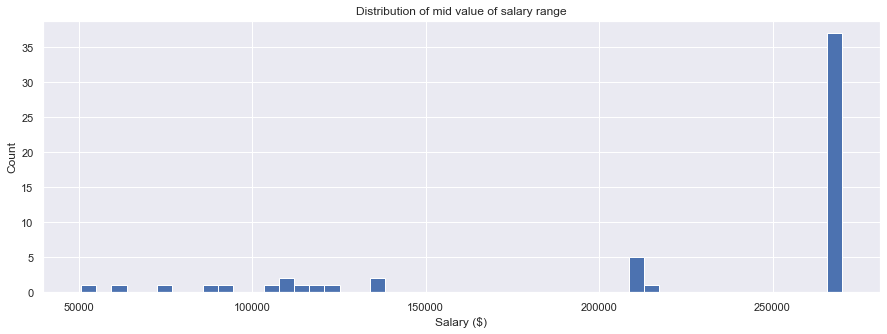

In [261]:
plt.subplots(figsize = (15,5))
data.SalaryMidValue.plot(kind='hist', bins=50)
plt.xlabel('Salary ($)')
plt.ylabel('Count')
plt.title('Distribution of mid value of salary range')
plt.show()

In [262]:
n_bins = int(np.sqrt((~data.SalaryMidValue.isnull()).sum()))


C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


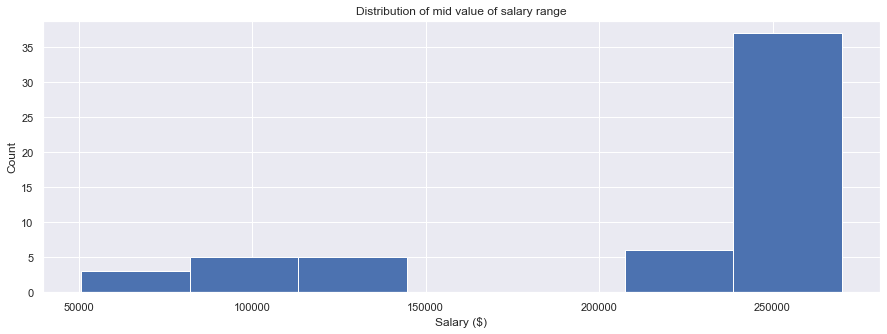

In [263]:
plt.subplots(figsize = (15,5));
plt.hist(data.SalaryMidValue,bins=n_bins);
plt.xlabel('Salary ($)');
plt.ylabel('Count');
plt.title('Distribution of mid value of salary range');
plt.show()

In [264]:
bin_edges=[ x for x in range(20000,260000, 5000)]
len(bin_edges)

48

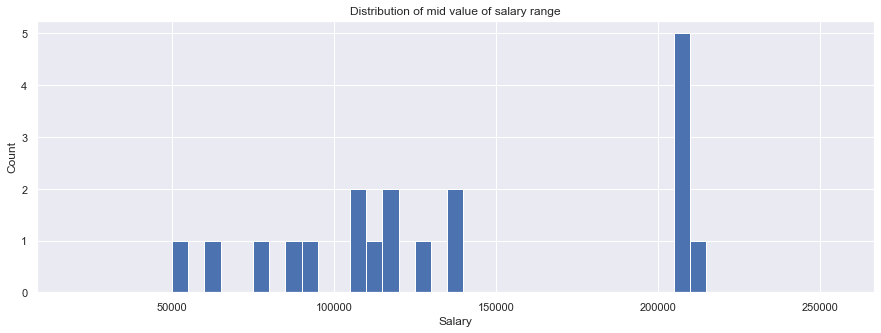

In [265]:
_=plt.subplots(figsize = (15,5))
_=plt.hist(data.SalaryMidValue,bins=bin_edges)
_=plt.xlabel('Salary')
_=plt.ylabel('Count')
_=plt.title('Distribution of mid value of salary range')
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1311: RuntimeWarning: invalid value encountered in less
  off_low = points < low_gutter
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1315: RuntimeWarning: invalid value encountered in greater
  off_high = points > high_gutter


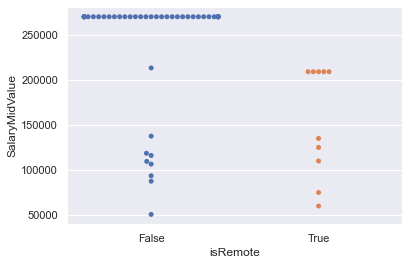

In [266]:
sns.swarmplot(y='SalaryMidValue', x='isRemote', data= data)
plt.show()

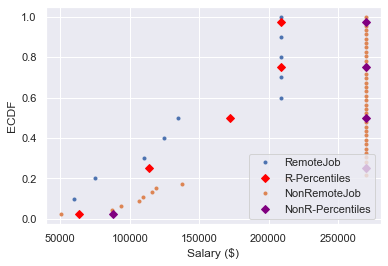

In [267]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)
    # x-data for the ECDF: x
    x = np.sort(data)
    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n
    return x, y

x_R,y_R = ecdf(data.loc[(~data.SalaryMidValue.isnull()) & (data.isRemote == True),'SalaryMidValue'])
plt.plot(x_R,y_R,marker='.',linestyle='none')

percentiles = np.array([2.5,25,50,75,97.5])
ptiles_xR = np.percentile(x_R,percentiles)
plt.plot(ptiles_xR, percentiles/100, marker='D', color='red', linestyle='none')

x,y = ecdf(data.loc[(~data.SalaryMidValue.isnull()) & (data.isRemote == False),'SalaryMidValue'])
plt.plot(x,y,marker='.',linestyle='none')
ptiles_x = np.percentile(x,percentiles)
plt.plot(ptiles_x, percentiles/100, marker='D', color='purple', linestyle='none')

plt.legend(('RemoteJob','R-Percentiles', 'NonRemoteJob','NonR-Percentiles'), loc='lower right')
plt.xlabel('Salary ($)')
plt.ylabel('ECDF')
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1311: RuntimeWarning: invalid value encountered in less
  off_low = points < low_gutter
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1315: RuntimeWarning: invalid value encountered in greater
  off_high = points > high_gutter


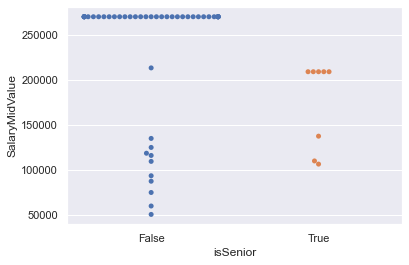

In [268]:
sns.swarmplot(y='SalaryMidValue', x='isSenior', data= data)
plt.show()

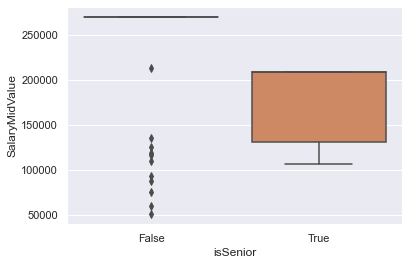

In [269]:
sns.boxplot(y='SalaryMidValue', x='isSenior', data= data)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1311: RuntimeWarning: invalid value encountered in less
  off_low = points < low_gutter
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1315: RuntimeWarning: invalid value encountered in greater
  off_high = points > high_gutter


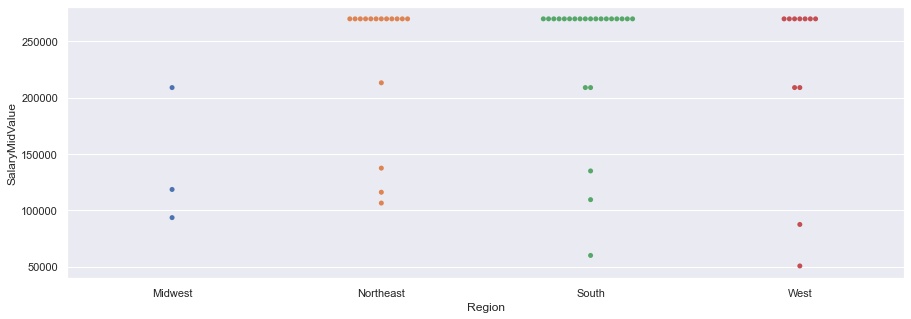

In [270]:
plt.subplots(figsize = (15,5))
sns.swarmplot(y='SalaryMidValue', x='Region', data= data)
plt.show()

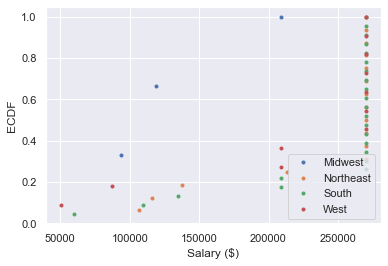

In [271]:
x,y = ecdf(data.loc[(~data.SalaryMidValue.isnull()) & (data.Region == 'Midwest'),'SalaryMidValue'])
plt.plot(x,y,marker='.',linestyle='none')

x,y = ecdf(data.loc[(~data.SalaryMidValue.isnull()) & (data.Region == 'Northeast'),'SalaryMidValue'])
plt.plot(x,y,marker='.',linestyle='none')

x,y = ecdf(data.loc[(~data.SalaryMidValue.isnull()) & (data.Region == 'South'),'SalaryMidValue'])
plt.plot(x,y,marker='.',linestyle='none')

x,y = ecdf(data.loc[(~data.SalaryMidValue.isnull()) & (data.Region == 'West'),'SalaryMidValue'])
plt.plot(x,y,marker='.',linestyle='none')

plt.legend(('Midwest', 'Northeast','South','West'), loc='lower right')
plt.xlabel('Salary ($)')
plt.ylabel('ECDF')
plt.show()

In [274]:
((data.SalaryMidValue <= 125000) & (data.SalaryMidValue > 100000)).sum()

6

In [276]:
assert data.SalaryMidValue.min() > 10000  

In [277]:
(data.SalaryMidValue < 100000).sum()

5

In [278]:
data.SalaryMidValue.isnull().sum()

167

In [279]:
data.loc[data.SalaryMidValue > 300000]

,JobID,JobTitle,Company,Location,CompanyRating,CompanyUrl,CompanyIndustry,CompanySize,PostDate,ExtractDate,...,isRemote,City,State,Region,isSenior,isJunior,isMid,SalaryUnit,SalaryMidValue,SalaryGroup


### Step 8:  Create a new varible 'CompanyRevenue'


In [289]:
company_df = pd.read_csv('../data/raw/Companies.csv')

In [290]:
company_df.shape

(7243, 10)

In [291]:
company_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7243 entries, 0 to 7242
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Name            190 non-null    object 
 1   CompanyUrl      7243 non-null   object 
 2   Size            6098 non-null   object 
 3   CompanyRevenue  4762 non-null   object 
 4   Industry        5812 non-null   object 
 5   CompanyCEO      2379 non-null   object 
 6   Founded         4803 non-null   float64
 7   Link            0 non-null      float64
 8   Detail          2051 non-null   object 
 9   AddDate         6641 non-null   object 
dtypes: float64(2), object(8)
memory usage: 566.0+ KB


In [292]:
company_df[company_df.duplicated()]

,Name,CompanyUrl,Size,CompanyRevenue,Industry,CompanyCEO,Founded,Link,Detail,AddDate


In [293]:
data_c=pd.merge(data,company_df, how='left', on='CompanyUrl')

In [294]:
data_c.loc[(~data_c['CompanySize'].isnull() ) & (data_c['CompanySize'] != data_c['Size'])]

,JobID,JobTitle,Company,Location,CompanyRating,CompanyUrl,CompanyIndustry,CompanySize,PostDate,ExtractDate,...,SalaryGroup,Name,Size,CompanyRevenue,Industry,CompanyCEO,Founded,Link,Detail,AddDate


In [295]:
data_c.loc[(~data_c['CompanyIndustry'].isnull() ) & (data_c['CompanyIndustry'] != data_c['Industry'])].CompanyUrl.value_counts()

https://www.indeed.com/cmp/The-Walt-Disney-Company    5
https://www.indeed.com/cmp/Guidehouse                 4
https://www.indeed.com/cmp/Pwc                        2
https://www.indeed.com/cmp/Craft                      1
https://www.indeed.com/cmp/Norton-Healthcare          1
Name: CompanyUrl, dtype: int64

In [296]:
data_c.loc[(~data_c['CompanyIndustry'].isnull() ) & (data_c['CompanyIndustry'] != data_c['Industry']),['JobID','CompanyUrl','CompanySize','Size','CompanyIndustry','Industry']].sort_values('CompanyUrl').head(10)

,JobID,CompanyUrl,CompanySize,Size,CompanyIndustry,Industry
55,784accb7b97682be,https://www.indeed.com/cmp/Craft,11 to 50,11 to 50,Crop Production,Manufacturing
3,7914f9c54eac131a,https://www.indeed.com/cmp/Guidehouse,"1001 to 5,000","1001 to 5,000",Healthcare,Hospitals & Health Clinics
66,7ef8786dfa5c8998,https://www.indeed.com/cmp/Guidehouse,"1001 to 5,000","1001 to 5,000",Healthcare,Hospitals & Health Clinics
122,b6583e86fd518910,https://www.indeed.com/cmp/Guidehouse,"1001 to 5,000","1001 to 5,000",Healthcare,Hospitals & Health Clinics
129,116dc9d394e9cee9,https://www.indeed.com/cmp/Guidehouse,"1001 to 5,000","1001 to 5,000",Healthcare,Hospitals & Health Clinics
11,2fe14da05228b4ea,https://www.indeed.com/cmp/Norton-Healthcare,"more than 10,000","more than 10,000",Healthcare,Hospitals & Health Clinics
78,f85ebcb227a8f60f,https://www.indeed.com/cmp/Pwc,"more than 10,000","more than 10,000",Staffing & Subcontracting,Financial Services
180,a7ba819e94e59613,https://www.indeed.com/cmp/Pwc,"more than 10,000","more than 10,000",Staffing & Subcontracting,Financial Services
68,421f4d6e511ced07,https://www.indeed.com/cmp/The-Walt-Disney-Com...,"more than 10,000","more than 10,000",Healthcare,Human Resources & Staffing
156,ec42af884bcf5047,https://www.indeed.com/cmp/The-Walt-Disney-Com...,"more than 10,000","more than 10,000",Healthcare,Human Resources & Staffing


In [297]:
data_c.loc[(~data_c['CompanyIndustry'].isnull() ) & (data_c['CompanyIndustry'] != data_c['Industry']),:]

,JobID,JobTitle,Company,Location,CompanyRating,CompanyUrl,CompanyIndustry,CompanySize,PostDate,ExtractDate,...,SalaryGroup,Name,Size,CompanyRevenue,Industry,CompanyCEO,Founded,Link,Detail,AddDate
3,7914f9c54eac131a,"Data Analyst- Consultant - Energy, Sustainabil...",Guidehouse,"Parsippany, NJ",3.4,https://www.indeed.com/cmp/Guidehouse,Healthcare,"1001 to 5,000",Just posted,2021-05-17,...,NaN,NaN,"1001 to 5,000",$1B to $5B (USD),Hospitals & Health Clinics,Scott McIntyre,1996.0,NaN,NaN,NaN
11,2fe14da05228b4ea,"Cancer Data Analyst, Norton Cancer Registry, Days",Norton Healthcare,"Louisville, KY",3.8,https://www.indeed.com/cmp/Norton-Healthcare,Healthcare,"more than 10,000",Just posted,2021-05-17,...,NaN,NaN,"more than 10,000",$1B to $5B (USD),Hospitals & Health Clinics,Russell F. Cox,NaN,NaN,NaN,3/15/2021
55,784accb7b97682be,"Software Engineer, US Remote",Craft,Washington State,3.6,https://www.indeed.com/cmp/Craft,Crop Production,11 to 50,Today,2021-05-17,...,NaN,NaN,11 to 50,NaN,Manufacturing,NaN,NaN,NaN,Company size11 to 50IndustryManufacturing,4/23/2021
66,7ef8786dfa5c8998,Data Science Platform Administrator,Guidehouse,"Washington Harbor, WA",3.4,https://www.indeed.com/cmp/Guidehouse,Healthcare,"1001 to 5,000",Just posted,2021-05-17,...,NaN,NaN,"1001 to 5,000",$1B to $5B (USD),Hospitals & Health Clinics,Scott McIntyre,1996.0,NaN,NaN,NaN
68,421f4d6e511ced07,Staff Data Scientist,The Walt Disney Company (Corporate),"Bremerton, WA",4.1,https://www.indeed.com/cmp/The-Walt-Disney-Com...,Healthcare,"more than 10,000",Today,2021-05-17,...,NaN,NaN,"more than 10,000",more than $10B (USD),Human Resources & Staffing,Robert Iger,1923.0,NaN,NaN,NaN
78,f85ebcb227a8f60f,Financial Services Data & Analytics Manager - ...,PRICE WATERHOUSE COOPERS,"Atlanta, GA",4.0,https://www.indeed.com/cmp/Pwc,Staffing & Subcontracting,"more than 10,000",Today,2021-05-17,...,NaN,NaN,"more than 10,000",more than $10B (USD),Financial Services,Robert E. Moritz | Chairman PwC International Ltd,1998.0,NaN,NaN,NaN
122,b6583e86fd518910,Data Science Platform Administrator,Guidehouse,"Suitland, MD",3.4,https://www.indeed.com/cmp/Guidehouse,Healthcare,"1001 to 5,000",Just posted,2021-05-17,...,NaN,NaN,"1001 to 5,000",$1B to $5B (USD),Hospitals & Health Clinics,Scott McIntyre,1996.0,NaN,NaN,NaN
129,116dc9d394e9cee9,"AI Data Scientist – Machine Learning, Senior C...",Guidehouse,"Naval Anacost Annex, DC",3.4,https://www.indeed.com/cmp/Guidehouse,Healthcare,"1001 to 5,000",Just posted,2021-05-17,...,NaN,NaN,"1001 to 5,000",$1B to $5B (USD),Hospitals & Health Clinics,Scott McIntyre,1996.0,NaN,NaN,NaN
156,ec42af884bcf5047,Staff Data Scientist,The Walt Disney Company (Corporate),"Burley, WA",4.1,https://www.indeed.com/cmp/The-Walt-Disney-Com...,Healthcare,"more than 10,000",Today,2021-05-17,...,NaN,NaN,"more than 10,000",more than $10B (USD),Human Resources & Staffing,Robert Iger,1923.0,NaN,NaN,NaN
159,179b2ea303e86205,Staff Data Scientist,The Walt Disney Company (Corporate),"Retsil, WA",4.1,https://www.indeed.com/cmp/The-Walt-Disney-Com...,Healthcare,"more than 10,000",Today,2021-05-17,...,NaN,NaN,"more than 10,000",more than $10B (USD),Human Resources & Staffing,Robert Iger,1923.0,NaN,NaN,NaN


In [300]:
data_c.loc[((data_c.CompanyIndustry.isnull()) & (~data_c.Industry.isnull())),:]

,JobID,JobTitle,Company,Location,CompanyRating,CompanyUrl,CompanyIndustry,CompanySize,PostDate,ExtractDate,...,SalaryGroup,Name,Size,CompanyRevenue,Industry,CompanyCEO,Founded,Link,Detail,AddDate


In [301]:
data_c.loc[((data_c.CompanySize.isnull()) & (~data_c.Size.isnull())),:]

,JobID,JobTitle,Company,Location,CompanyRating,CompanyUrl,CompanyIndustry,CompanySize,PostDate,ExtractDate,...,SalaryGroup,Name,Size,CompanyRevenue,Industry,CompanyCEO,Founded,Link,Detail,AddDate


In [312]:
data_c.CompanyRevenue.unique()

array([nan, '$1B to $5B (USD)', '$100M to $500M (USD)',
       '$25M to $100M (USD)', '$500M to $1B (USD)', '$5B to $10B (USD)',
       'more than $10B (USD)', 'Hidden by employer', '$5M to $25M (USD)'],
      dtype=object)

In [303]:
data['CompanyRevenue'] =pd.merge(data,company_df, how='left', on='CompanyUrl').CompanyRevenue

In [338]:
data['CompanyRevenue'] =data.CompanyRevenue.str.replace(' to ','-').str.replace(r" \(.*\)",'').str.replace('more than ','>').str.replace('Hidden by employer','').replace('',np.NaN)

### Step 9: Create a new vriable 'CompanySizeGroup'

In [69]:
companySizeGroup_mapping={'1001 to 5,000':'Large', 'more than 10,000':'Extra-Large', '5,001 to 10,000':'Large','501 to 1,000':'Midsize','201 to 500':'Midsize', '51 to 200':'Small',  '11 to 50':'Extra-Small'}

In [70]:
data['CompanySizeGroup'] = data.loc[~data.CompanySize.isnull(), 'CompanySize'].map(companySizeGroup_mapping).astype('category')

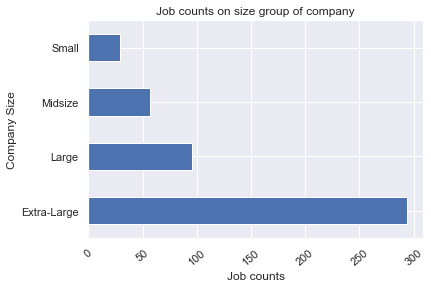

In [71]:
data.CompanySizeGroup.value_counts().plot(kind='barh')
plt.xticks(rotation ='40')
plt.ylabel('Company Size')
plt.xlabel('Job counts')
plt.title('Job counts on size group of company')
plt.show()

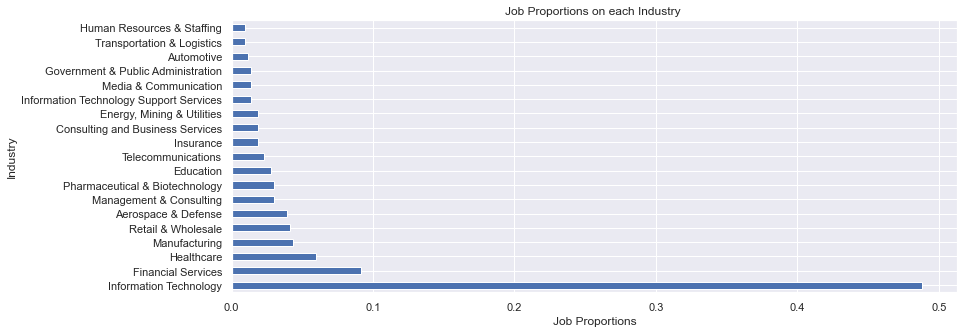

In [145]:
plt.subplots(figsize=(13,5))

data.groupby('CompanyIndustry').filter(lambda x: len(x) >3)['CompanyIndustry'].value_counts(normalize='True').plot(kind = 'barh')
#data.CompanyIndustry.value_counts().plot(kind='barh')
plt.xlabel('Job Proportions')
plt.ylabel('Industry')
plt.title('Job Proportions on each Industry ')
plt.show()

### Step 10: Create new variables 'isDA', 'isDS', 'isML', 'isAI' from job Title

In [ ]:
data['isDA'] = data.JobTitle.str.contains('Data') & data.JobTitle.str.contains('Analy')

data['isDS'] = data.JobTitle.str.contains('Data') & data.JobTitle.str.contains('Scien')

data['isML'] = data.JobTitle.str.contains('Machine') & data.JobTitle.str.contains('Lear')

data['isAI'] = data.JobTitle.str.contains('Artific')

### Step 11: Drop unnecessary columns for Capstone 2 project

In [2630]:
data.shape

(2330, 24)

In [2631]:
# Drop few columns not needed for further analysis
s_data = data.drop(columns = ['PostDate','ExtractDate','Remote', 'JobUrl','JobID','Location','Location_imp','CompanyUrl','CompanySize','Summary', 'Salary','SalaryUnit','JobDetail','JobDescription','DatePosted'])

In [2632]:
s_data.shape

(2330, 20)

### Step 12: Save the dataset in interim folder

In [2633]:
# Add project path
import os
import sys
parent_project_path = os.path.abspath(os.path.join('..'))
if parent_project_path not in sys.path:
    sys.path.append(parent_project_path)


In [2634]:
# save the data to a new csv file

datapath = '../data/interim/'
fileName = '{0}_daily.csv'.format(today)
save_file(s_data, fileName, datapath)

Writing file.  "../data/interim/2021_02_25_daily.csv"


In [2511]:
set(data.loc[data.Company.str.contains('Amazon Dev Center U.S., Inc.',na=False),'JobID']).intersection(id_3)

{'0422fe8200778dbc',
 '0b45b1e572e1acb5',
 '0c1c1fb03d034642',
 '250fac673af5d56e',
 '336c87397051ab0e',
 '3cdef97c29a9ca72',
 '3cef31376293ef0d',
 '68b4930c04a0a5a1',
 '794a4a69e78081ea',
 '7d1c76ca060cd84a',
 '891a32bad15ed2aa',
 '89c1fa946ee99ec7',
 '924892b80ebb4fbf',
 'b7a7d3951ced4974',
 'c84dd74b68f5505a',
 'd2512be3e3e13d3b',
 'd5cdf793ad8fbfc0',
 'e0165c707517e063'}

In [2512]:
data.loc[(data.Company.str.contains('Pearson',na=False)) & (data.State == 'NJ')]

,JobID,JobTitle,Company,Location,CompanyRating,PostDate,ExtractDate,Summary,Salary,Remote,...,isRemote,City,State,Region,isSenior,isJunior,isMid,SalaryUnit,SalaryMidValue,SalaryGroup
1315,eaf90bfb3312ddc3,Analytics and Insights Analyst,Pearson,"Trenton, NJ",3.8,Just posted,2021-02-24,Description We are the world’s learning compan...,NaN,Remote,...,True,Trenton,NJ,Northeast,False,False,False,NaN,NaN,NaN


In [2627]:
data.loc[data.Location == 'United States']

,JobID,JobTitle,Company,Location,CompanyRating,PostDate,ExtractDate,Summary,Salary,Remote,...,isRemote,City,State,Region,isSenior,isJunior,isMid,SalaryUnit,SalaryMidValue,SalaryGroup
44,19f0387c2f370d8f,Cost and Data Analyst,Ibex Hc Llc,United States,NaN,Today,2021-02-25,"Building Locally, Leading Nationally Top 50 Ho...",NaN,NaN,...,False,NaN,NaN,NaN,False,False,False,NaN,NaN,NaN
282,928d10cb5d8dd78f,Director Collateral Operations,Farm Credit Mid-America,United States,3.8,1 day ago,2021-02-25,Standardize customer communications to resolve...,NaN,NaN,...,False,NaN,NaN,NaN,True,False,False,NaN,NaN,NaN
339,cf7ff47b512b1a55,Data Scientist Apprentice,IBM,United States,3.9,1 day ago,2021-02-25,You will apply the scientific method to busine...,NaN,NaN,...,False,NaN,NaN,NaN,False,False,False,NaN,NaN,NaN
340,21ac57c4f1499d84,Data Science Resident,Galvanize Inc.,United States,4.1,Today,2021-02-25,"As part of the Residency program, you will rec...",$35 an hour,NaN,...,False,NaN,NaN,NaN,False,False,False,an hour,72800.0,50K-75k
346,3fc66107e2e3fda5,SOS Data Science Engineer,IBM,United States,3.9,1 day ago,2021-02-25,Optimize data retrieval and develop new dashbo...,NaN,NaN,...,False,NaN,NaN,NaN,False,False,False,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2064,bea0373a5cdb4e0a,"Associate Partner, SAP S/4 HANA - Electronics",IBM,United States,3.9,1 day ago,2021-02-25,This is a hands-on sales and delivery role.\nR...,NaN,NaN,...,False,NaN,NaN,NaN,False,False,False,NaN,NaN,NaN
2083,1495e99efdb35097,SAP Financial Services Associate Partner,IBM,United States,3.9,1 day ago,2021-02-25,"Define, develop and use repeatable non-traditi...",NaN,NaN,...,False,NaN,NaN,NaN,False,False,False,NaN,NaN,NaN
2201,f849ea5778ba35ae,GBSD Sr Principal Engr S/W,Northrop Grumman,United States,4.0,Today,2021-02-25,Design and develop artificial intelligence alg...,NaN,NaN,...,False,NaN,NaN,NaN,True,False,False,NaN,NaN,NaN
2269,d95fd163663ea3a8,"Associate Partner, SAP S/4 HANA - Automotive, ...",IBM,United States,3.9,1 day ago,2021-02-25,Introduction As a Business Sales & Delivery Ex...,NaN,NaN,...,False,NaN,NaN,NaN,False,False,False,NaN,NaN,NaN


In [148]:
#To do list: 
# check missing state  : done ! 
# categorize state: done !
# check dup id : done ! 
# salay categorizing : done!
# remove unneeded columns, save in the interim folder: done!
# run today's data without dedup line in the data collection loop:   done!
# run 2021_02_17 again to fix monthly salary data error: not necessary, since we may not using those data.  done!
# To check detailed description with np.nan value: done!
# make library using package: add project path to sys.path done!
# Try do get more infor from job decription: nothing can be done!
# put it together after a week of trials: done!
# To check the result with new search string in use for more relevence, especially look for salary data: done! 

# find a better way to split Location, to auto treat the case which only contains state information but not ','???
# find a way to create contigency table by using group by instead of crosstab:
# create a log writer

# LOG:
# 2/24/21(W): 4 datasets, second day including 'AI' dataset, first time avg salary above $10k. Start including detailed 
# salary information in the daily file. 
# 2/25/21(TH): 4 datasets.
# 3/1/21(M): From 2/28, adding CompanySize, CompanyUrl, CompanyIndustry, and CompanySizeGroup, in Interim fils
# 5/12/21: starting only get top 200 of records from each file into the dataset
# 5/17/21: adding a new variable 'CompanyRevenue', if location is 'united states' then regard it as 'isRemote'
# 5/18/21: add random imputation which replace 'Remote' and 'United States' values with some
# random observed values of the Location, which has about 10% missing rate

# Note:
# 1: some big companies could have up to two digits job posting within one day. I can dive deep into analysis on specific 
# company 
# 2: may consider not including data analyst or analytics, ...tried without ','

## Putting it all together

In [4]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pandas_profiling
from pandas_profiling.utils.cache import cache_file
import os
import sys
import seaborn as sns
import schedule
import time 

def RunMain():

    sns.set()

    # Add project path
    parent_project_path = os.path.abspath(os.path.join('..'))
    if parent_project_path not in sys.path:
        sys.path.append(parent_project_path)
    from src.library.sb_utils import save_file

    #step 1: To combine 4 datasets into one dataframe
    today = datetime.today().strftime('%Y_%m_%d')
    #today = '2021_03_16'
    dfNames=['da','ds','ml','ai']
    data = pd.DataFrame()

    for n in dfNames:
        fileName = '../data/raw/{0}_last{1}d_RC_{2}.csv'.format(n,'1', today)
        df = pd.read_csv(fileName, skiprows=[0])

        #combine 4 files together
        if n == 'da':
            data = data.append(df.head(int(df.shape[0] * 0.3)), ignore_index=True)
        else:
            if df.shape[0] * 0.5 >200:
                data = data.append(df.head(200), ignore_index=True)
            else:
                data = data.append(df.head(int(df.shape[0] * 0.5)), ignore_index=True)     

    #step 2: To de-dup the records in the combined datasets
    print("Duplicated JobIDs: " + str(data.duplicated(subset ='JobID').sum()))
    data.drop_duplicates(subset = 'JobID', inplace= True)
    # To reindex 
    data.index = np.arange(0,len(data))

    #step 3: To create a new date variable 'DatePosted' by remove the string from 'PostDate' and convert to int
    data['DatePosted'] = data.PostDate.str.replace('day ago|days ago','').str.replace('Today|Just posted','0').str.strip().astype(int)
    # To convert 'ExtractDate' to datetime type
    data['ExtractDate'] = pd.to_datetime(data['ExtractDate'])
    # To Convert 'DatePosted' from int to timeDelta type and compute the exact date when the job was posted 
    data.DatePosted = pd.to_timedelta(data.DatePosted, unit='D')
    data.DatePosted = pd.to_datetime(data['ExtractDate'] - data['DatePosted'])

    #step 4: To create a new boolean variable 'isRemote' and assign Ture if varible 'Remote' OR 'Location' is Remote
    data['isRemote'] = (data.Remote == 'Remote') | data.Location.str.contains('Remote|United States')

    #step 5: To create three new variables City, State and Region
    # random imputation will replace 'Remote' and 'United States' values with some
    # random observed values of the Location, which has about 10% missing rate
    data['Location_imp'] = data.Location
    data.Location_imp = data.Location_imp.str.replace('Remote|United States','').replace('',np.NaN)
    number_missing = data.Location_imp.isnull().sum()
    observed_values = data.loc[data.Location_imp.notnull(),'Location']
    data.loc[data.Location_imp.isnull(), 'Location_imp'] = np.random.choice(observed_values, number_missing, replace=True)

    newDf = data.Location_imp.str.split(pat =',',expand =True)
    data['City'] = newDf[0]
    data['State'] = newDf[1]
    # To clean up values of City, after random imputation, the following may not be necessary
    data.loc[data.City == 'Remote', 'City'] = np.nan
    data.loc[data.City == 'United States', 'City'] = np.nan
    # To fill the missing value of 'State' from 'City' for those which has only location of State 
    data.State.fillna(data.City, inplace=True)
    # To clean up values in 'City'
    data.loc[data.State == data.City, 'City'] = np.nan
    # To clean up the value of 'Washington DC' on variable 'City'
    data.loc[(data.City == 'Washington') & (data.State == 'DC'), 'City'] ='DC'
    us_state_abbrev = {'Alabama': 'AL','Alaska': 'AK','American Samoa': 'AS','Arizona': 'AZ','Arkansas': 'AR','California': 'CA','Colorado': 'CO','Connecticut': 'CT',
        'Delaware': 'DE','District of Columbia': 'DC','Florida': 'FL','Georgia': 'GA','Guam': 'GU',
        'Hawaii': 'HI', 'Idaho': 'ID','Illinois': 'IL', 'Indiana': 'IN','Iowa': 'IA', 'Kansas': 'KS','Kentucky': 'KY', 'Louisiana': 'LA',
        'Maine': 'ME','Maryland': 'MD','Massachusetts': 'MA','Michigan': 'MI','Minnesota': 'MN','Mississippi': 'MS','Missouri': 'MO','Montana': 'MT', 'Nebraska': 'NE',
        'Nevada': 'NV','New Hampshire': 'NH','New Jersey': 'NJ','New Mexico': 'NM','New York': 'NY','North Carolina': 'NC',
        'North Dakota': 'ND','Northern Mariana Islands':'MP','Ohio': 'OH', 'Oklahoma': 'OK','Oregon': 'OR', 'Pennsylvania': 'PA',
        'Puerto Rico': 'PR', 'Rhode Island': 'RI','South Carolina': 'SC','South Dakota': 'SD','Tennessee': 'TN',  'Texas': 'TX','Utah': 'UT',
        'Vermont': 'VT','Virgin Islands': 'VI','Virginia': 'VA','Washington': 'WA','West Virginia': 'WV','Wisconsin': 'WI', 'Wyoming': 'WY'
    }
    # To extract State abbrevation value from City variables to fill those missing values into 'State'
    data.loc[data.State.str.len() >3,'State']=data.loc[data.State.str.len() >3,'State'].str.replace(' State','').map(us_state_abbrev)
    # To clean up the State values
    data.State= data.State.str.strip()

    # To categorize state value into 4 regions 
    us_state_regions = {'Alabama': 'South','Alaska': 'West','American Samoa': 'Islands',
        'Arizona': 'West','Arkansas': 'South','California': 'West','Colorado': 'West',
        'Connecticut': 'Northeast', 'Delaware': 'South','District of Columbia': 'South','Florida': 'South',
        'Georgia': 'South', 'Guam': 'Islands','Hawaii': 'West',  'Idaho': 'West',
        'Illinois': 'Midwest', 'Indiana': 'Midwest','Iowa': 'Midwest','Kansas': 'Midwest','Kentucky': 'South',
        'Louisiana': 'South','Maine': 'Northeast','Maryland': 'South', 'Massachusetts': 'Northeast',
        'Michigan': 'Midwest','Minnesota': 'Midwest','Mississippi': 'South','Missouri': 'Midwest',
        'Montana': 'West', 'Nebraska': 'Midwest','Nevada': 'West','New Hampshire': 'Northeast', 'New Jersey': 'Northeast',
        'New Mexico': 'West', 'New York': 'Northeast', 'North Carolina': 'South','North Dakota': 'Midwest', 'Northern Mariana Islands':'Islands',
        'Ohio': 'Midwest','Oklahoma': 'South', 'Oregon': 'West','Pennsylvania': 'Northeast','Puerto Rico': 'Islands',
        'Rhode Island': 'Northeast','South Carolina': 'South','South Dakota': 'Midwest','Tennessee': 'South',
        'Texas': 'South','Utah': 'West','Vermont': 'Northeast','Virgin Islands': 'Islands','Virginia': 'South',
        'Washington': 'West','West Virginia': 'South','Wisconsin': 'Midwest','Wyoming': 'West'}
    # To create a new variable 'Region' by mapping to the dict
    us_state_regions_mapping =  {v: us_state_regions[k] for k, v in us_state_abbrev.items()}
    data['Region'] = data.loc[~data.State.isnull(),'State'].map(us_state_regions_mapping).astype('category')

    data.Region.value_counts().plot(kind='bar')
    plt.ylabel('Job counts')
    plt.xlabel('Region')
    plt.xticks(rotation=40)
    plt.title('Job counts on each 5 regions')
    plt.show()

    plt.subplots(figsize=(20, 5))
    data.State.value_counts().plot(kind='bar')
    plt.ylabel('Job counts')
    plt.xlabel('State')
    plt.title('Job counts on each state with more than 0 openings')
    plt.show()

    plt.subplots(figsize=(20, 5))
    data.groupby('City').filter(lambda x: len(x) >5 )['City'].value_counts().plot(kind='bar')
    plt.xticks(rotation=40)
    plt.ylabel('Job counts')
    plt.xlabel('City')
    plt.title('Job counts on each city with more than 5 openings')
    plt.show()     

    print("Princeton jobs: ",data.City.str.contains('Princeton').sum())

    #step 6: To create new variables 'isSenior', 'isJunior','isMid'
    data['isSenior'] = data.JobTitle.str.contains('Senior|Sr|sr|Director|VP|Lead|Principal|Chief')
    data['isJunior'] = data.JobTitle.str.contains('Junior|Jr|jr|Intern')
    data['isMid'] = data.JobTitle.str.contains('Mid Level|Mid-')

    #step 7: To create new variables 'SalaryUnit', 'SalaryMidValue' and 'SalaryGroup'
    # To create a new variable 'SalaryUnit'
    data['SalaryUnit'] = data.Salary.str.extract('(an hour|a year|a month|a week|per class|a day)', expand = True)

    # To create a new variable 'SalaryMidValue' going to contain the mid point value for the arrange of salary
    # Set busniss rule to treat range: take mid value of a range and Ignore 'Up to' and 'From' 
    data['SalaryMidValue'] = data.Salary.str.replace('[^0-9-.]','')

    # Take mid value for range salary
    s_df = data.SalaryMidValue.str.split(pat ='-',expand =True)
    s_df[1].fillna(s_df[0], inplace=True)
    data['SalaryMidValue']  = (s_df[1].astype(float)+s_df[0].astype(float))/2

    # Convert hourly rate to Salary based on formula hr * 40 * 52 
    data.loc[data.SalaryUnit.str.contains('hour', na=False),'SalaryMidValue'] = data.SalaryMidValue * 40 * 52
    # Convert monthly rate to Salary based on formula mr * 12
    data.loc[data.SalaryUnit.str.contains('month', na=False),'SalaryMidValue'] = data.SalaryMidValue * 12
    # Convert weekly rate to Salary based on fomula wr * 52 
    data.loc[data.SalaryUnit.str.contains('week', na = False), 'SalaryMidValue'] =data.SalaryMidValue * 52
    # Convert daily rate to Salary based on formula dr * 5 * 52
    data.loc[data.SalaryUnit.str.contains('day', na=False),'SalaryMidValue'] = data.SalaryMidValue * 5 * 52
    # Ignore the teaching job
    data.loc[data.SalaryUnit.str.contains('class', na=False),'SalaryMidValue'] = np.nan

    print(data.SalaryMidValue.describe())
    data.SalaryMidValue.plot(kind='box')
    plt.show()

    plt.subplots(figsize = (15,5))
    data.SalaryMidValue.plot(kind='hist', bins=50)
    plt.xlabel('Salary')
    plt.ylabel('Count')
    plt.title('Distribution of mid value of salary range')
    plt.show()

    #step 8: To create a new variable 'CompanyRevenue'
    company_df = pd.read_csv('../data/raw/Companies.csv')
    data['CompanyRevenue'] =pd.merge(data,company_df, how='left', on='CompanyUrl').CompanyRevenue
    data['CompanyRevenue'] =data.CompanyRevenue.str.replace(' to ','-').str.replace(r" \(.*\)",'').str.replace('more than ','>').str.replace('Hidden by employer','').replace('',np.NaN)
    
    #step 9: To create a new variable 'CompanySizeGroup'
    companySizeGroup_mapping={'1001 to 5,000':'Large', 'more than 10,000':'Extra-Large', '5,001 to 10,000':'Large','501 to 1,000':'Midsize','201 to 500':'Midsize', '51 to 200':'Small',  '11 to 50':'Small'}
    data['CompanySizeGroup'] = data.loc[~data.CompanySize.isnull(), 'CompanySize'].map(companySizeGroup_mapping).astype('category')

    data.CompanySizeGroup.value_counts().plot(kind='barh')
    plt.xticks(rotation ='40')
    plt.ylabel('Company Size')
    plt.xlabel('Job counts')
    plt.title('Job counts on size group of company')
    plt.show()

    plt.subplots(figsize=(20,10))
    data.groupby('CompanyIndustry').filter(lambda x: len(x) >3)['CompanyIndustry'].value_counts(normalize='True').plot(kind = 'barh')
    #data.CompanyIndustry.value_counts().plot(kind='barh')
    plt.xlabel('Job Proportions')
    plt.ylabel('Industry')
    plt.title('Job Proportions on each Industry with more than 3 openings')
    plt.show()

    #step 10: Create new variables 'isDA', 'isDS', 'isML', 'isAI' from job Title
    data['isDA'] = data.JobTitle.str.contains('Data') & data.JobTitle.str.contains('Analy')
    data['isDS'] = data.JobTitle.str.contains('Data') & data.JobTitle.str.contains('Scien')
    data['isML'] = data.JobTitle.str.contains('Machine') & data.JobTitle.str.contains('Lear')
    data['isAI'] = data.JobTitle.str.contains('Artific')

    #step 11: Drop few columns not needed for further analysis
    s_data = data.drop(columns = ['PostDate','ExtractDate','Remote', 'JobUrl','JobID','Location','Location_imp','CompanyUrl','CompanySize','Summary', 'Salary','SalaryUnit','JobDetail','JobDescription','DatePosted'])
    
    #step 12: Save the processed df into interim folder as a new csv file
    datapath = '../data/interim/'
    fileName = '{0}_daily.csv'.format(today)
    save_file(s_data, fileName, datapath)



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Duplicated JobIDs: 3


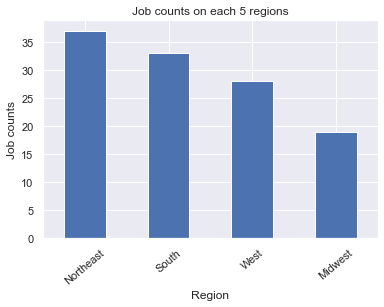

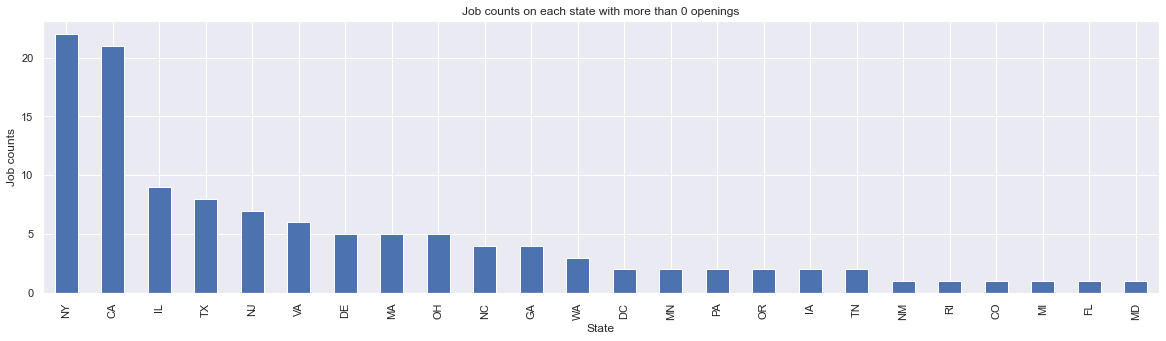

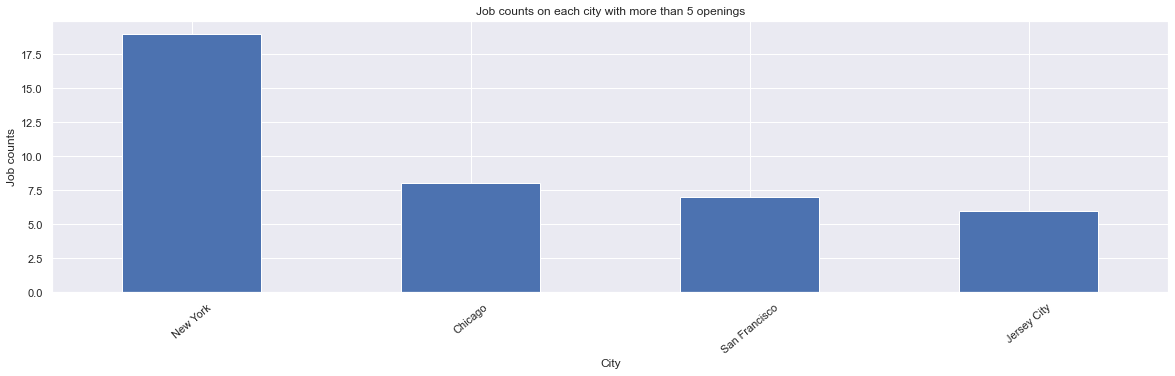

Princeton jobs:  0
count         7.000000
mean     121506.700000
std       52868.945214
min       65000.000000
25%       75506.200000
50%      120000.000000
75%      161250.000000
max      192034.500000
Name: SalaryMidValue, dtype: float64


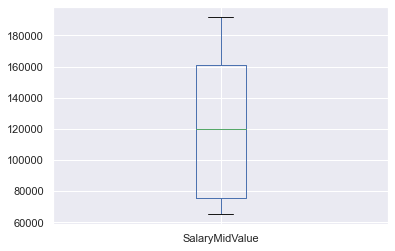

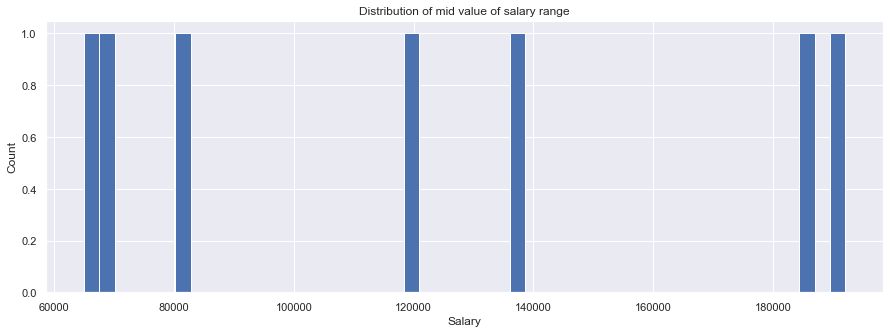

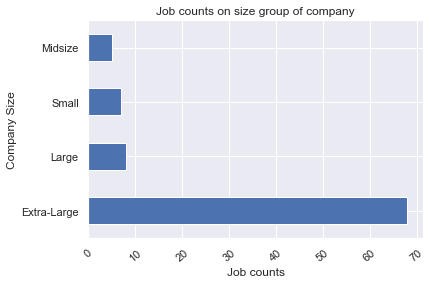

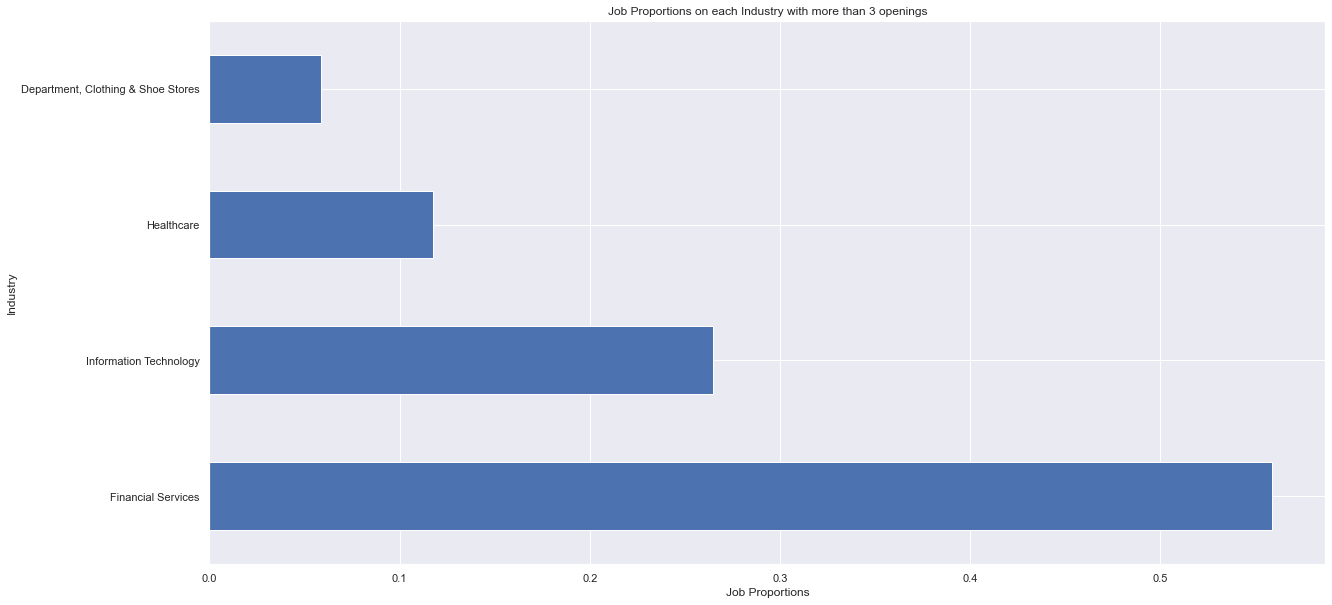

Writing file.  "../data/interim/2021_06_01_daily.csv"


In [5]:
RunMain()

Duplicated JobIDs: 284


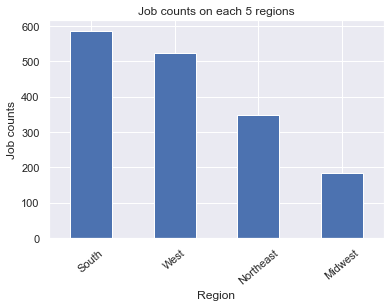

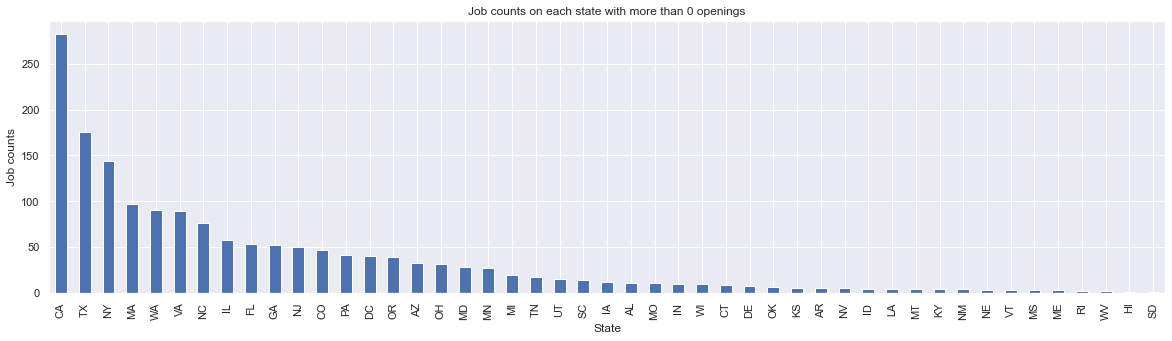

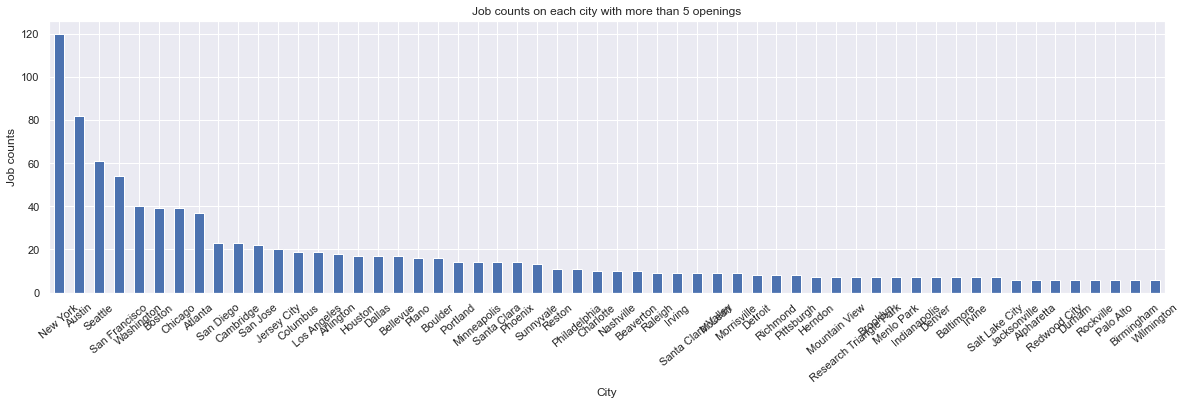

Princeton jobs:  4
count       259.000000
mean     160527.184942
std       88783.769044
min       20800.000000
25%       81537.500000
50%      130000.000000
75%      270000.000000
max      270000.000000
Name: SalaryMidValue, dtype: float64


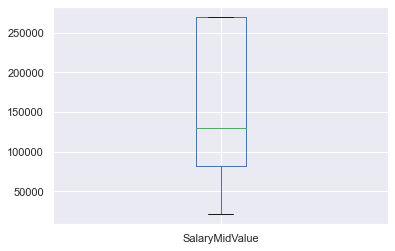

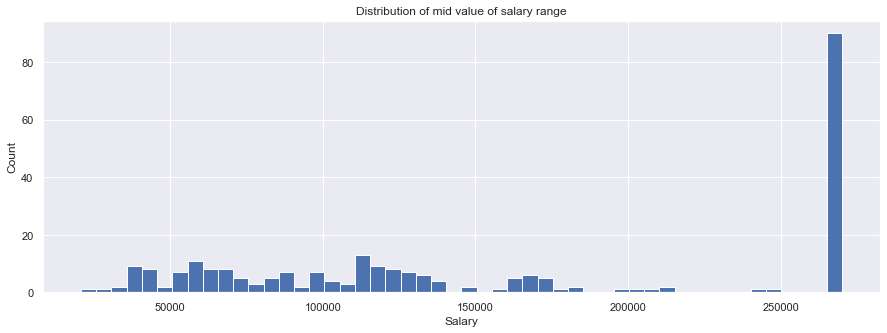

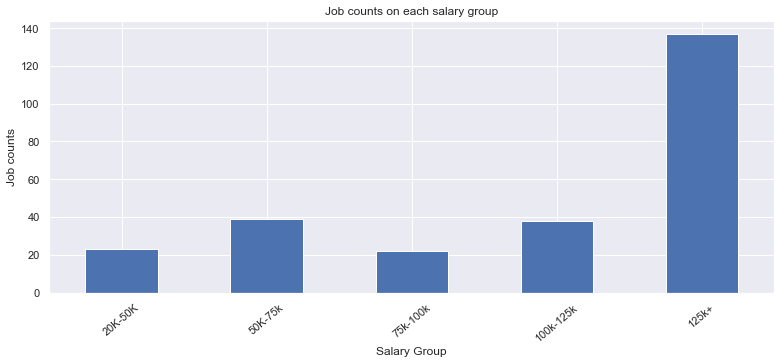

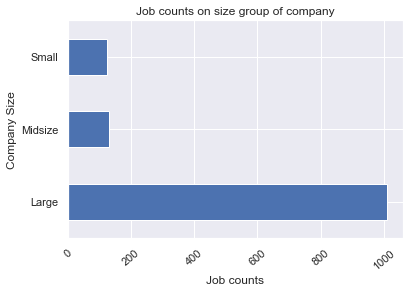

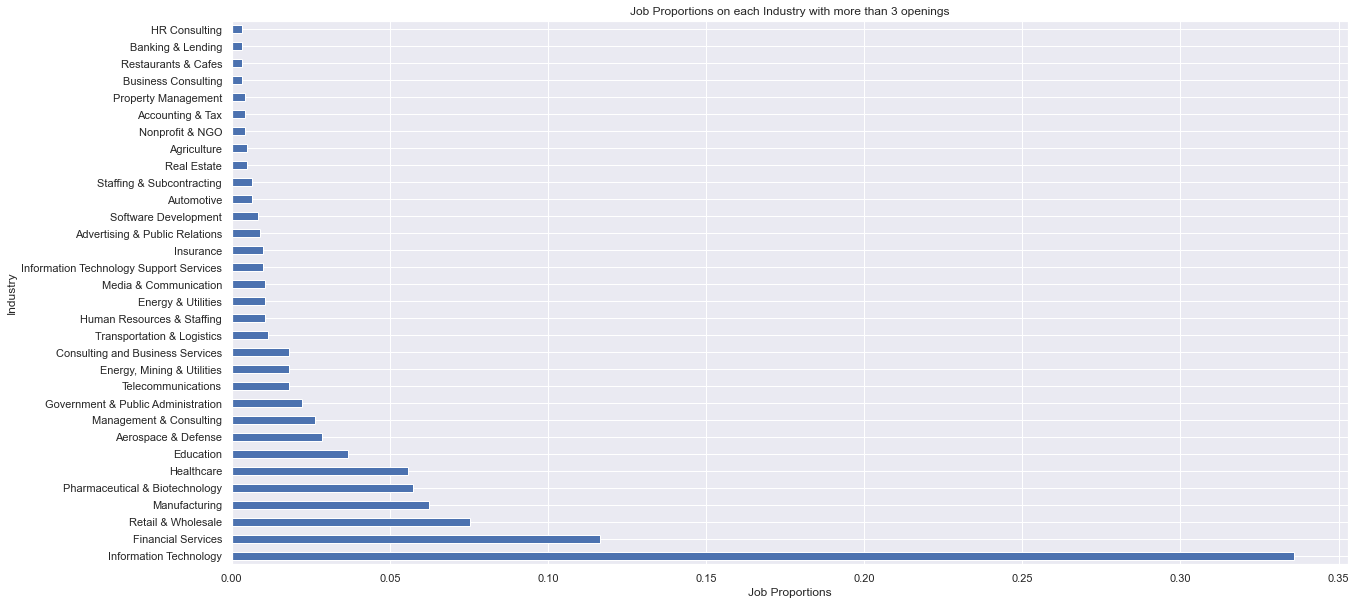


Writing file.  "../data/interim/2021_04_24_daily.csv"
Duplicated JobIDs: 148


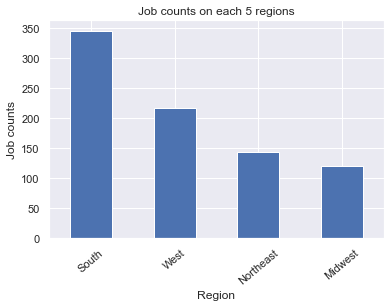

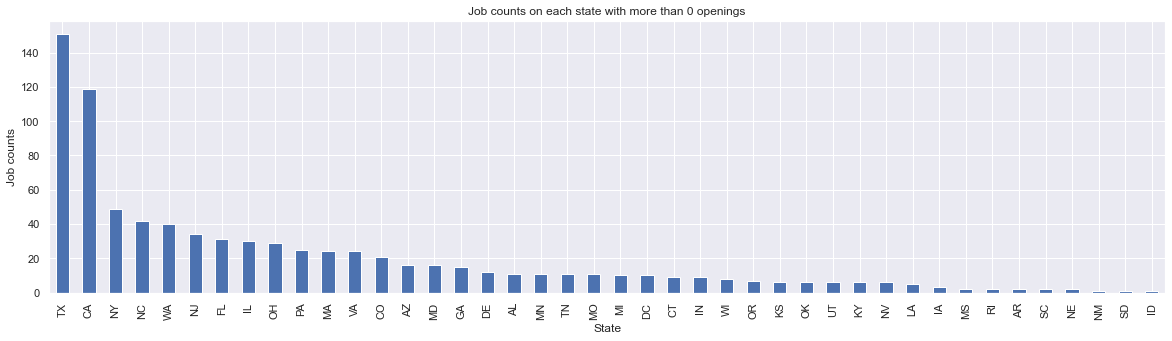

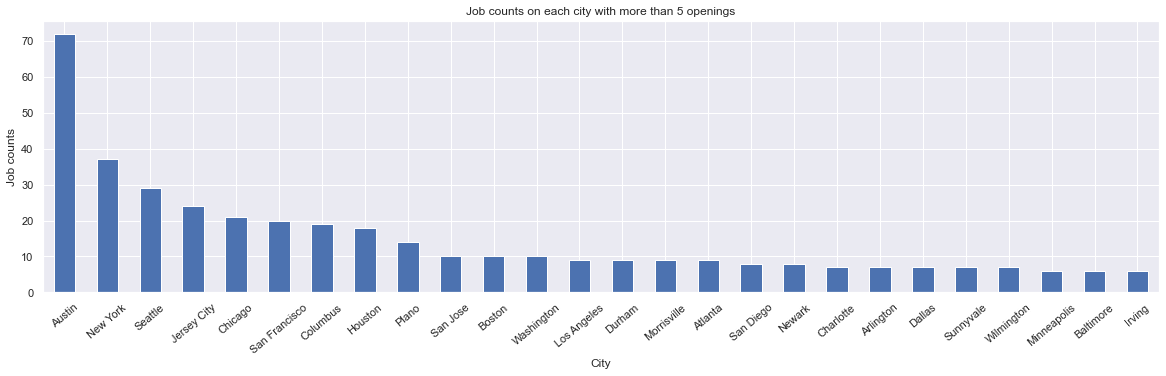

Princeton jobs:  2
count       225.000000
mean     238807.172889
std       68155.465688
min       24700.000000
25%      270000.000000
50%      270000.000000
75%      270000.000000
max      270000.000000
Name: SalaryMidValue, dtype: float64


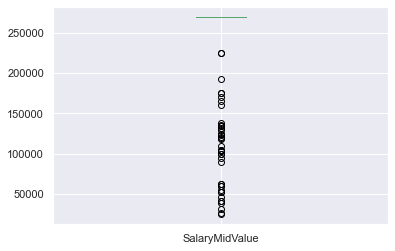

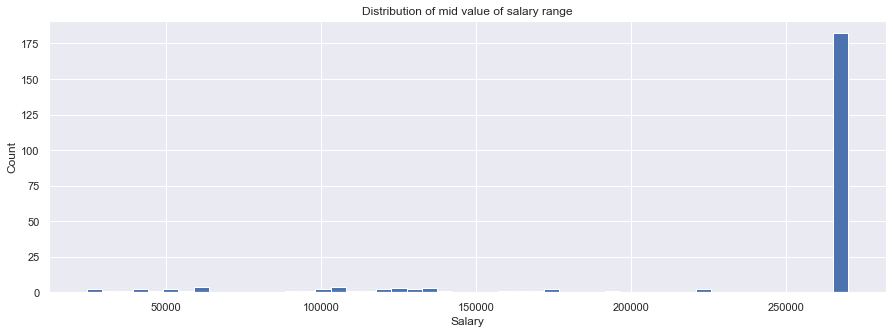

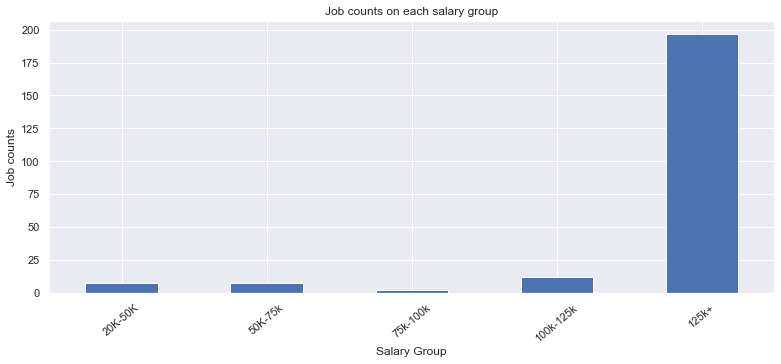

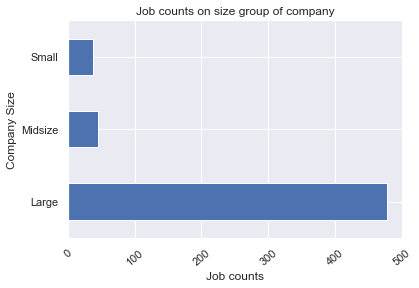

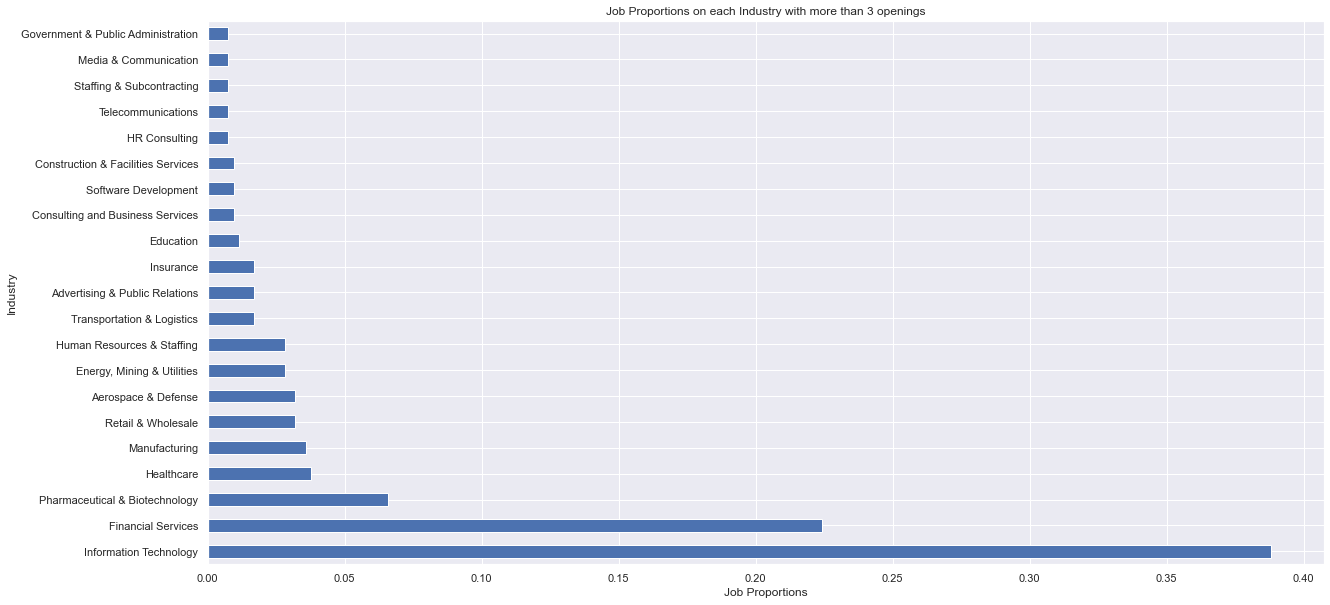


Writing file.  "../data/interim/2021_04_25_daily.csv"


In [ ]:
schedule.every().day.at('12:30').do(RunMain)

while True:
    schedule.run_pending()
    time.sleep(1)